# Initial tinkering with E. coli iModulon data to see if we can train a CNN to learn M-matrix values

In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


import altair as alt
import seaborn as sns
import torch_utils as tu

import torch

In [26]:
import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import r2_score

from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping,Checkpoint,GradientNormClipping
from skorch.dataset import Dataset
from skorch.helper import predefined_split


## Load data

In [3]:
fname = 'ec_iMod_out/ecoli_seq_M_opFilt.tsv' 
XY = pd.read_csv(fname,sep='\t')

display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(loc2seq['b3575'])

,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,82,83,84,85,86,87,88,89,90,91
0,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0.008229,-0.000685,-0.005215,...,-0.006856,0.010676,0.008874,0.018497,0.000700,-0.013267,0.015265,0.016886,-0.015319,-0.020727
1,b0007,yaaJ,putative transporter YaaJ,CDS,-1,6528,AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...,0.008111,-0.003929,0.003207,...,-0.000337,-0.010468,0.016122,0.010361,-0.003899,-0.022839,-0.003665,-0.001823,-0.023604,-0.012765
2,b0008,talB,transaldolase B,CDS,1,8237,ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...,0.008629,-0.001270,-0.005664,...,0.000394,0.007215,-0.000707,-0.012959,-0.002329,0.006391,-0.003650,-0.008537,0.002898,-0.000891
3,b0009,mog,molybdopterin adenylyltransferase,CDS,1,9305,AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...,0.002952,0.002053,-0.002882,...,-0.009291,-0.000226,0.016013,0.002179,0.004891,-0.002365,-0.003490,-0.006066,-0.011982,0.011477
4,b0010,satP,acetate/succinate:H(+) symporter,CDS,-1,9927,CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...,0.006142,0.000884,0.008166,...,-0.009214,-0.010588,0.001363,0.003979,-0.005208,0.003190,-0.015137,-0.005784,-0.001302,0.010800


TCAATCAGCATCAACCCGCGAAACAGACTCTGGCTTCCGGCTGGACGCTCTTTTTCCTGCGCCATCTCGTTCTCTTTTTTTCCCATCACTTCTTTCCCCATTTTGTCGCGTCCTGATGGTAGCGCAAAGTGTGCCGTAGTTCACGATCTCGACAGATAATTTATAACCAATTGATTTTTATGTCTTTTGAAATTCATCAATCAGATTGCCTTGTTAAAAAGTGATCGATATATTTGAAATCAAGTTTCGCATATTGAAATTTTAAGCCAAAAAAGCGATCAAAAAAACAAGGAAGCCTGG


In [5]:
def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

(1703, 100)
(426, 100)
(1362, 101)
(341, 101)


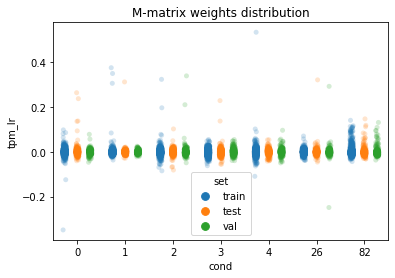

In [8]:
# Split data into train/test/split here and now
full_train_df,test_df = tu.quick_split(XY)
train_df, val_df = tu.quick_split(full_train_df)

print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)


coi = ['0','1','2','3','4','26','82']
assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])
view_train_test_dist(train_df, test_df,coi,"M-matrix weights",val_df=val_df)

## convert to skorch-able dfs

In [9]:
# get iModulon column labels
M = pd.read_csv('ec_iMod_out/iMod_download/M.csv',index_col=0)
imods = M.columns
imods[:5]

Index(['0', '1', '2', '3', '4'], dtype='object')

In [10]:
def make_mt_skorch_dfs(df,seq_col='seq',target_cols=['highCu','noCu']):
    '''
    Make multi-task X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [12]:
X, y = make_mt_skorch_dfs(XY, seq_col="upstream_region",target_cols=imods)
print("\nX:",X.shape)
print("y:",y.shape)

Xtrain, ytrain = make_mt_skorch_dfs(train_df, seq_col="upstream_region",target_cols=imods)
print("\nXtrain:",Xtrain.shape)
print("ytrain:",ytrain.shape)

Xval, yval = make_mt_skorch_dfs(val_df, seq_col="upstream_region",target_cols=imods)
print("\nXval:",Xval.shape)
print("yval:",yval.shape)

Xtest, ytest = make_mt_skorch_dfs(test_df, seq_col="upstream_region",target_cols=imods)
print("\nXtest:",Xtest.shape)
print("ytest:",ytest.shape)

Xfull_train, yfull_train = make_mt_skorch_dfs(full_train_df, seq_col="upstream_region",target_cols=imods)
print("\nXfull_train:",Xfull_train.shape)
print("yfull_train:",yfull_train.shape)


X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 92])

Xtrain: torch.Size([1362, 300, 4])
ytrain: torch.Size([1362, 92])

Xval: torch.Size([341, 300, 4])
yval: torch.Size([341, 92])

Xtest: torch.Size([426, 300, 4])
ytest: torch.Size([426, 92])

Xfull_train: torch.Size([1703, 300, 4])
yfull_train: torch.Size([1703, 92])


In [22]:
# make skorch predefined valid ds
#valid_ds = Dataset(Xval, yval)

## pick some params

In [13]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [37]:
# just pick some
# Adam, 32 filt, fast LR
net_regr1 = NeuralNetRegressor(
    m.DNA_2CNN_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=64,
    module__num_filters2=64,
    module__kernel_size1=12,
    module__kernel_size2=6,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.01,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)


In [38]:
net_regr1.fit(Xfull_train, yfull_train)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0054        0.0047     +  0.0966
      2        0.0051        0.0044     +  0.0964
      3        0.0048        0.0042     +  0.0714
      4        0.0046        0.0040     +  0.0706
      5        0.0044        0.0038     +  0.0683
      6        0.0043        0.0037     +  0.0601
      7        0.0041        0.0036     +  0.0599
      8        0.0040        0.0035     +  0.0600
      9        0.0039        0.0034     +  0.0609
     10        0.0038        0.0034     +  0.0597
     11        0.0037        0.0033     +  0.0598
     12        0.0037        0.0032     +  0.0599
     13        0.0036        0.0032     +  0.0603
     14        0.0035        0.0031     +  0.0599
     15        0.0035        0.0031     +  0.0612
     16        0.0034        0.0030     +  0.0599
     17        0.0034        0.0030     +  0.0601
     18        0.0033        0.0030     +  0.0600


    121        0.0016        0.0014     +  0.0603
    122        0.0016        0.0014     +  0.0601
    123        0.0016        0.0014     +  0.0603
    124        0.0016        0.0014     +  0.0602
    125        0.0016        0.0014     +  0.0602
    126        0.0016        0.0014     +  0.0601
    127        0.0016        0.0014     +  0.0604
    128        0.0015        0.0013     +  0.0601
    129        0.0015        0.0013     +  0.0601
    130        0.0015        0.0013     +  0.0605
    131        0.0015        0.0013     +  0.0599
    132        0.0015        0.0013     +  0.0600
    133        0.0015        0.0013     +  0.0599
    134        0.0015        0.0013     +  0.0602
    135        0.0015        0.0013     +  0.0600
    136        0.0015        0.0013     +  0.0601
    137        0.0015        0.0013     +  0.0604
    138        0.0015        0.0013     +  0.0608
    139        0.0015        0.0013     +  0.0607
    140        0.0015        0.0013     +  0.0613


    243        0.0009        0.0008     +  0.0604
    244        0.0009        0.0008     +  0.0612
    245        0.0009        0.0008     +  0.0611
    246        0.0009        0.0008     +  0.0605
    247        0.0009        0.0007     +  0.0605
    248        0.0009        0.0007     +  0.0605
    249        0.0009        0.0007     +  0.0608
    250        0.0009        0.0007     +  0.0603
    251        0.0009        0.0007     +  0.0613
    252        0.0009        0.0007     +  0.0613
    253        0.0009        0.0007     +  0.0605
    254        0.0009        0.0007     +  0.0603
    255        0.0009        0.0007     +  0.0606
    256        0.0009        0.0007     +  0.0609
    257        0.0009        0.0007     +  0.0612
    258        0.0009        0.0007     +  0.0613
    259        0.0009        0.0007     +  0.0612
    260        0.0009        0.0007     +  0.0610
    261        0.0009        0.0007     +  0.0607
    262        0.0009        0.0007     +  0.0608


    370        0.0007        0.0005     +  0.0654
    371        0.0007        0.0005     +  0.0663
    372        0.0007        0.0005     +  0.0659
    373        0.0007        0.0005     +  0.0666
    374        0.0007        0.0005     +  0.0659
    375        0.0007        0.0005     +  0.0654
    376        0.0007        0.0005     +  0.0653
    377        0.0006        0.0005     +  0.0648
    378        0.0007        0.0005     +  0.0652
    379        0.0006        0.0005     +  0.0649
    380        0.0006        0.0005     +  0.0649
    381        0.0006        0.0005     +  0.0650
    382        0.0006        0.0005     +  0.0651
    383        0.0006        0.0005     +  0.0655
    384        0.0006        0.0005     +  0.0651
    385        0.0006        0.0005     +  0.0651
    386        0.0006        0.0005     +  0.0653
    387        0.0006        0.0005     +  0.0651
    388        0.0006        0.0005     +  0.0653
    389        0.0006        0.0005     +  0.0651


    501        0.0005        0.0004     +  0.0664
    502        0.0005        0.0004     +  0.0657
    503        0.0005        0.0004     +  0.0657
    504        0.0005        0.0004     +  0.0651
    505        0.0005        0.0004     +  0.0653
    506        0.0005        0.0004     +  0.0650
    507        0.0005        0.0004     +  0.0661
    508        0.0005        0.0004     +  0.0665
    509        0.0005        0.0004     +  0.0658
    510        0.0005        0.0004     +  0.0658
    511        0.0005        0.0004     +  0.0661
    512        0.0005        0.0004     +  0.0659
    513        0.0005        0.0004     +  0.0665
    514        0.0005        0.0004     +  0.0669
    515        0.0005        0.0004     +  0.0670
    516        0.0005        0.0004     +  0.0676
    517        0.0005        0.0004     +  0.0662
    518        0.0005        0.0004     +  0.0663
    519        0.0005        0.0004     +  0.0678
    520        0.0005        0.0004     +  0.0670


    634        0.0005        0.0003     +  0.0655
    635        0.0005        0.0003     +  0.0658
    636        0.0005        0.0003     +  0.0656
    637        0.0005        0.0003     +  0.0657
    638        0.0005        0.0003     +  0.0657
    639        0.0005        0.0003     +  0.0679
    640        0.0005        0.0003     +  0.0680
    641        0.0005        0.0003     +  0.0676
    642        0.0005        0.0003     +  0.0695
    643        0.0005        0.0003     +  0.0689
    644        0.0005        0.0003     +  0.0671
    645        0.0005        0.0003     +  0.0667
    646        0.0005        0.0003     +  0.0671
    647        0.0005        0.0003     +  0.0675
    648        0.0005        0.0003     +  0.0671
    649        0.0005        0.0003     +  0.0667
    650        0.0005        0.0003     +  0.0671
    651        0.0005        0.0003     +  0.0668
    652        0.0005        0.0003     +  0.0671
    653        0.0005        0.0003     +  0.0666


    769        0.0004        0.0003     +  0.0749
    770        0.0004        0.0003     +  0.0746
    771        0.0004        0.0003     +  0.0765
    772        0.0004        0.0003     +  0.0764
    773        0.0004        0.0003     +  0.0769
    774        0.0004        0.0003     +  0.0762
    775        0.0004        0.0003     +  0.0770
    776        0.0004        0.0003     +  0.0762
    777        0.0004        0.0003     +  0.0756
    778        0.0004        0.0003     +  0.0751
    779        0.0004        0.0003     +  0.0752
    780        0.0004        0.0003     +  0.0748
    781        0.0004        0.0003     +  0.0748
    782        0.0004        0.0003     +  0.0756
    783        0.0004        0.0003     +  0.0743
    784        0.0004        0.0003     +  0.0751
    785        0.0004        0.0003     +  0.0747
    786        0.0004        0.0003     +  0.0765
    787        0.0004        0.0003     +  0.0748
    788        0.0004        0.0003     +  0.0755


    905        0.0004        0.0003     +  0.0970
    906        0.0004        0.0003     +  0.0969
    907        0.0004        0.0003     +  0.0959
    908        0.0004        0.0003     +  0.0960
    909        0.0004        0.0003     +  0.0958
    910        0.0004        0.0003     +  0.0970
    911        0.0004        0.0003     +  0.0978
    912        0.0004        0.0003     +  0.0968
    913        0.0004        0.0003     +  0.0983
    914        0.0004        0.0003     +  0.0961
    915        0.0004        0.0003     +  0.0964
    916        0.0004        0.0003     +  0.0969
    917        0.0004        0.0003     +  0.0977
    918        0.0004        0.0003     +  0.0987
    919        0.0004        0.0003     +  0.0969
    920        0.0004        0.0003     +  0.0974
    921        0.0004        0.0003     +  0.0978
    922        0.0004        0.0003     +  0.0973
    923        0.0004        0.0003     +  0.0970
    924        0.0004        0.0003     +  0.0974


   1042        0.0004        0.0003     +  0.0972
   1043        0.0004        0.0003     +  0.0973
   1044        0.0004        0.0003     +  0.0975
   1045        0.0004        0.0003     +  0.0974
   1046        0.0004        0.0003     +  0.0974
   1047        0.0004        0.0003     +  0.0976
   1048        0.0004        0.0003     +  0.0985
   1049        0.0004        0.0003     +  0.0988
   1050        0.0004        0.0003     +  0.0990
   1051        0.0004        0.0003     +  0.0992
   1052        0.0004        0.0003     +  0.0983
   1053        0.0004        0.0003     +  0.0976
   1054        0.0004        0.0003     +  0.0988
   1055        0.0004        0.0003     +  0.0980
   1056        0.0004        0.0003     +  0.0986
   1057        0.0004        0.0003     +  0.0979
   1058        0.0004        0.0003     +  0.0980
   1059        0.0004        0.0003     +  0.0987
   1060        0.0004        0.0003     +  0.0982
   1061        0.0004        0.0003     +  0.0982


   1180        0.0004        0.0003     +  0.0899
   1181        0.0004        0.0003     +  0.0916
   1182        0.0004        0.0003     +  0.0914
   1183        0.0004        0.0003     +  0.0928
   1184        0.0004        0.0003     +  0.0940
   1185        0.0004        0.0003     +  0.0957
   1186        0.0004        0.0003     +  0.0969
   1187        0.0004        0.0003     +  0.0975
   1188        0.0004        0.0003     +  0.0978
   1189        0.0004        0.0003     +  0.0975
   1190        0.0004        0.0003     +  0.0976
   1191        0.0004        0.0003     +  0.0978
   1192        0.0004        0.0003     +  0.0977
   1193        0.0004        0.0003     +  0.0980
   1194        0.0004        0.0003     +  0.0979
   1195        0.0004        0.0003     +  0.0991
   1196        0.0004        0.0003        0.0982
   1197        0.0004        0.0003     +  0.0965
   1198        0.0004        0.0003     +  0.0753
   1199        0.0004        0.0003     +  0.0754


   1319        0.0004        0.0003     +  0.0989
   1320        0.0004        0.0003     +  0.1009
   1321        0.0004        0.0003        0.0989
   1322        0.0004        0.0003     +  0.0984
   1323        0.0004        0.0003     +  0.0731
   1324        0.0004        0.0003     +  0.0731
   1325        0.0004        0.0003        0.0741
   1326        0.0004        0.0003        0.0725
   1327        0.0004        0.0003        0.0725
   1328        0.0004        0.0003     +  0.0650
   1329        0.0004        0.0003        0.0625
   1330        0.0004        0.0003     +  0.0611
   1331        0.0004        0.0003     +  0.0622
   1332        0.0004        0.0003     +  0.0622
   1333        0.0004        0.0003        0.0627
   1334        0.0004        0.0003     +  0.0612
   1335        0.0004        0.0003     +  0.0625
   1336        0.0004        0.0003     +  0.0617
   1337        0.0004        0.0003     +  0.0618
   1338        0.0004        0.0003     +  0.0619


   1459        0.0004        0.0003     +  0.0630
   1460        0.0004        0.0003     +  0.0630
   1461        0.0004        0.0003        0.0797
   1462        0.0004        0.0003        0.0772
   1463        0.0004        0.0003     +  0.0731
   1464        0.0004        0.0003     +  0.0749
   1465        0.0004        0.0003     +  0.0739
   1466        0.0004        0.0003     +  0.0745
   1467        0.0004        0.0003     +  0.0741
   1468        0.0004        0.0003     +  0.0746
   1469        0.0004        0.0003     +  0.0740
   1470        0.0004        0.0003     +  0.0736
   1471        0.0004        0.0003     +  0.0930
   1472        0.0004        0.0003     +  0.0930
   1473        0.0004        0.0003     +  0.0941
   1474        0.0004        0.0003     +  0.0958
   1475        0.0004        0.0003     +  0.0994
   1476        0.0004        0.0003     +  0.0982
   1477        0.0004        0.0003     +  0.0988
   1478        0.0004        0.0003     +  0.0988


   1600        0.0004        0.0003     +  0.0743
   1601        0.0004        0.0003     +  0.0741
   1602        0.0004        0.0003     +  0.0900
   1603        0.0004        0.0003     +  0.0912
   1604        0.0004        0.0003     +  0.0952
   1605        0.0004        0.0003     +  0.0971
   1606        0.0004        0.0003     +  0.0984
   1607        0.0004        0.0003     +  0.0983
   1608        0.0004        0.0003     +  0.0983
   1609        0.0004        0.0003     +  0.0992
   1610        0.0004        0.0003     +  0.0984
   1611        0.0004        0.0003        0.0990
   1612        0.0004        0.0003     +  0.0978
   1613        0.0004        0.0003        0.0762
   1614        0.0004        0.0003     +  0.0746
   1615        0.0004        0.0003     +  0.0765
   1616        0.0004        0.0003        0.0753
   1617        0.0004        0.0003     +  0.0736
   1618        0.0004        0.0003        0.0759
   1619        0.0004        0.0003     +  0.0755


   1745        0.0004        0.0003     +  0.0616
   1746        0.0004        0.0003     +  0.0619
   1747        0.0004        0.0003        0.0620
   1748        0.0004        0.0003     +  0.0608
   1749        0.0004        0.0003        0.0622
   1750        0.0004        0.0003        0.0603
   1751        0.0004        0.0003     +  0.0610
   1752        0.0004        0.0003     +  0.0622
   1753        0.0004        0.0003     +  0.0622
   1754        0.0004        0.0003     +  0.0623
   1755        0.0004        0.0003     +  0.0624
   1756        0.0004        0.0003     +  0.0622
   1757        0.0004        0.0003     +  0.0622
   1758        0.0004        0.0003        0.0625
   1759        0.0004        0.0003        0.0611
   1760        0.0004        0.0003     +  0.0614
   1761        0.0004        0.0003        0.0625
   1762        0.0004        0.0003        0.0612
   1763        0.0004        0.0003        0.0611
   1764        0.0004        0.0003     +  0.0605


   1892        0.0004        0.0003        0.0725
   1893        0.0004        0.0003     +  0.0711
   1894        0.0003        0.0003     +  0.0716
   1895        0.0004        0.0003     +  0.0717
   1896        0.0004        0.0003     +  0.0717
   1897        0.0004        0.0003     +  0.0719
   1898        0.0004        0.0003        0.0881
   1899        0.0004        0.0003        0.0878
   1900        0.0004        0.0003        0.0877
   1901        0.0004        0.0003        0.0716
   1902        0.0004        0.0003        0.0679
   1903        0.0004        0.0003        0.0679
   1904        0.0003        0.0003     +  0.0617
   1905        0.0004        0.0003     +  0.0622
   1906        0.0004        0.0003        0.0619
   1907        0.0003        0.0003     +  0.0605
   1908        0.0004        0.0003     +  0.0620
   1909        0.0004        0.0003     +  0.0623
   1910        0.0004        0.0003     +  0.0617
   1911        0.0003        0.0003     +  0.0617


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 12), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(1, 6), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5824, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=92, bias=True)
    )
  ),
)

# Viz model results

In [39]:
def sk_loss_plot(nets):
    fig = plt.figure(figsize=(20,10))
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']

#         plt.plot(train_loss, 'o-', label='training')
#         plt.plot(valid_loss, 'o-', label='validation')
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=0.75,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')

    #plt.ylim(0,0.001)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
def parity_plot(title,ytrue,ypred, r2,rigid=False):
    plt.scatter(ytrue, ypred, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    #plt.title(f"{model_name} (pearson:{pearson:.3f})",fontsize=20)
    plt.title(f"{title} (r2:{r2:.3f})",fontsize=20)
    plt.show()

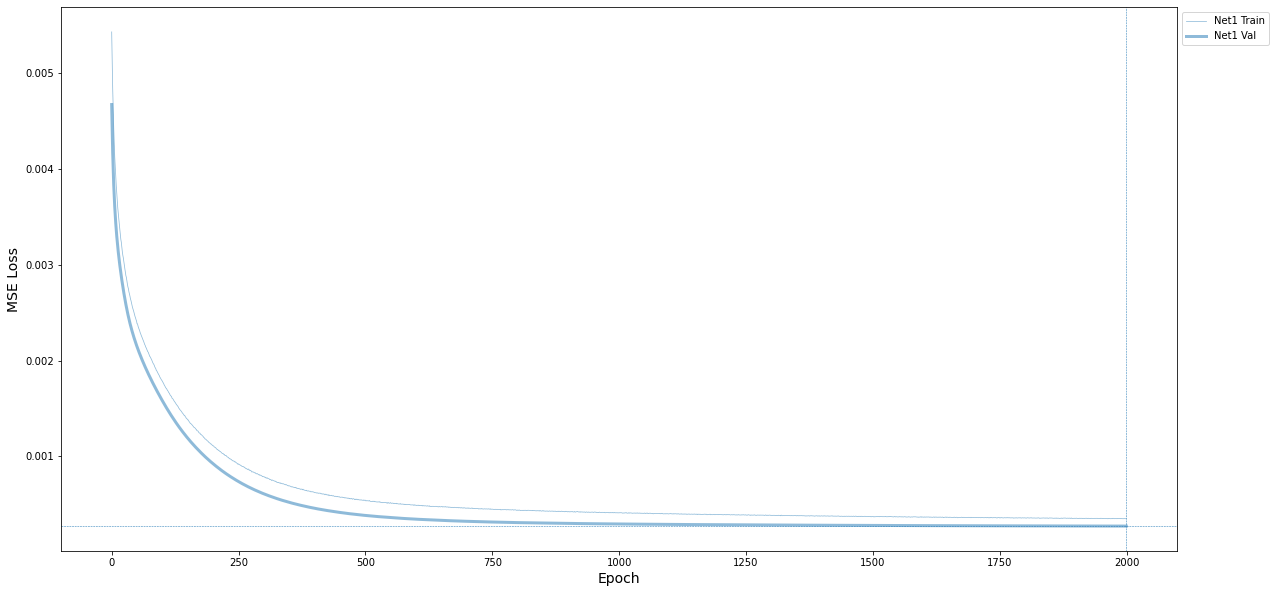

In [40]:
nets = [
    (net_regr1,'Net1'),
]

sk_loss_plot(nets)

YTRUE torch.Size([1362, 92])
**** ave r2:     -0.17307931543953395
**** r2 overall: -0.1730793169585597
YTRUE torch.Size([341, 92])
**** ave r2:     -0.22421296228947246
**** r2 overall: -0.22421296367562396


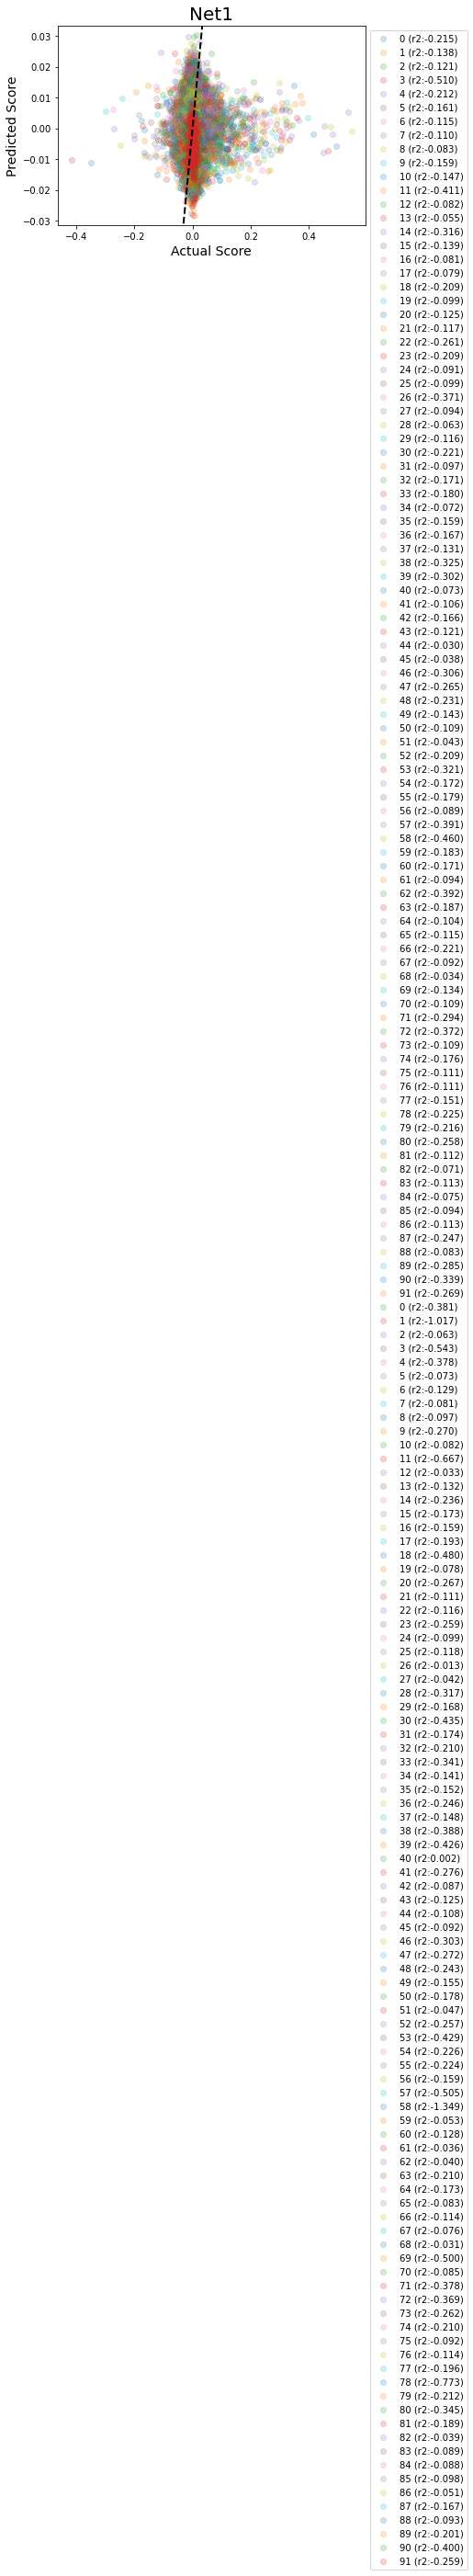

In [41]:
def parity_plot_comb(title,true_preds,rigid=False):
    all_net_r2s = []
    for (ytrue, ypred,name) in true_preds:
        print("YTRUE",ytrue.shape)
#         print("YPRED",ypred.shape)
        r2s = []
        for i in range(ytrue.shape[1]):
            ytruei = ytrue[:,i]
            ypredi = ypred[:,i]
            r2i = r2_score(ytruei,ypredi)
            #print(f"r2 {i}", r2i)
            r2s.append(r2i)
            plt.scatter(ytruei, ypredi, alpha=0.2,label=f"{i} (r2:{r2i:.3f})")
            
        r2 = r2_score(ytrue,ypred)
        r2i_mean = np.mean(r2s)
        print(f"**** ave r2:    ", r2i_mean)
        print(f"**** r2 overall:", r2)
        
        #plt.scatter(ytrue, ypred, alpha=0.2,label=f"{name} (r2:{r2:.3f})")
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    #plt.title(f"{model_name} (pearson:{pearson:.3f})",fontsize=20)
    plt.title(f"{title}",fontsize=20)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

def view_preds(nets):
    # for each network to plot
    for (net,name) in nets:
        ytrain_pred = net.predict(Xtrain)
        yval_pred = net.predict(Xval)
        
#         print(ytrain_pred.shape)
#         print(yval_pred.shape)

        plot_list = [
            (ytrain,ytrain_pred,"train"),
            (yval,yval_pred,"val"),
        ]
        parity_plot_comb(name, plot_list)


#view_preds(nets[::-1])
view_preds(nets)

In [42]:
def view_multi_parity(title,ytrue,ypred,rigid=False, num_cols=8):
        
    num_plts = ytrue.shape[1]
    num_rows = int(np.ceil(num_plts/num_cols))
    
    max_point = max(max(ytrue.flatten()),max(ypred.flatten()))
    min_point = min(min(ytrue.flatten()),min(ypred.flatten()))
    
    plt.figure(figsize=(15, 20))
    

    for c in range(ytrue.shape[1]):
        
        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols,c+1)
        yt = ytrue[:,c]
        yp = ypred[:,c]
        p = scipy.stats.pearsonr(yt,yp)[0]
        r2 = r2_score(yt,yp)
        
        ax1.scatter(yt,yp,color=f'C{c}',label=c,alpha=0.2)
        #ax1.set_title(f"{cond_dict[c]} (pearsonr:{p:.3f})")
        #ax1.set_title(f"{cond_dict[c]} (p:{p:.3f})")
        ax1.set_title(f"{c} (r2:{r2:.3f})")
        if rigid:
            plt.ylim(min_point,max_point)
        ax1.plot([min_point,max_point], [min_point,max_point], linestyle='--', color='k', lw=2, scalex=False, scaley=False)
        #plt.xlabel("Actual Value")
        #plt.ylabel("Predicted Value")
    plt.suptitle(title,fontsize=22)
    
    plt.tight_layout()

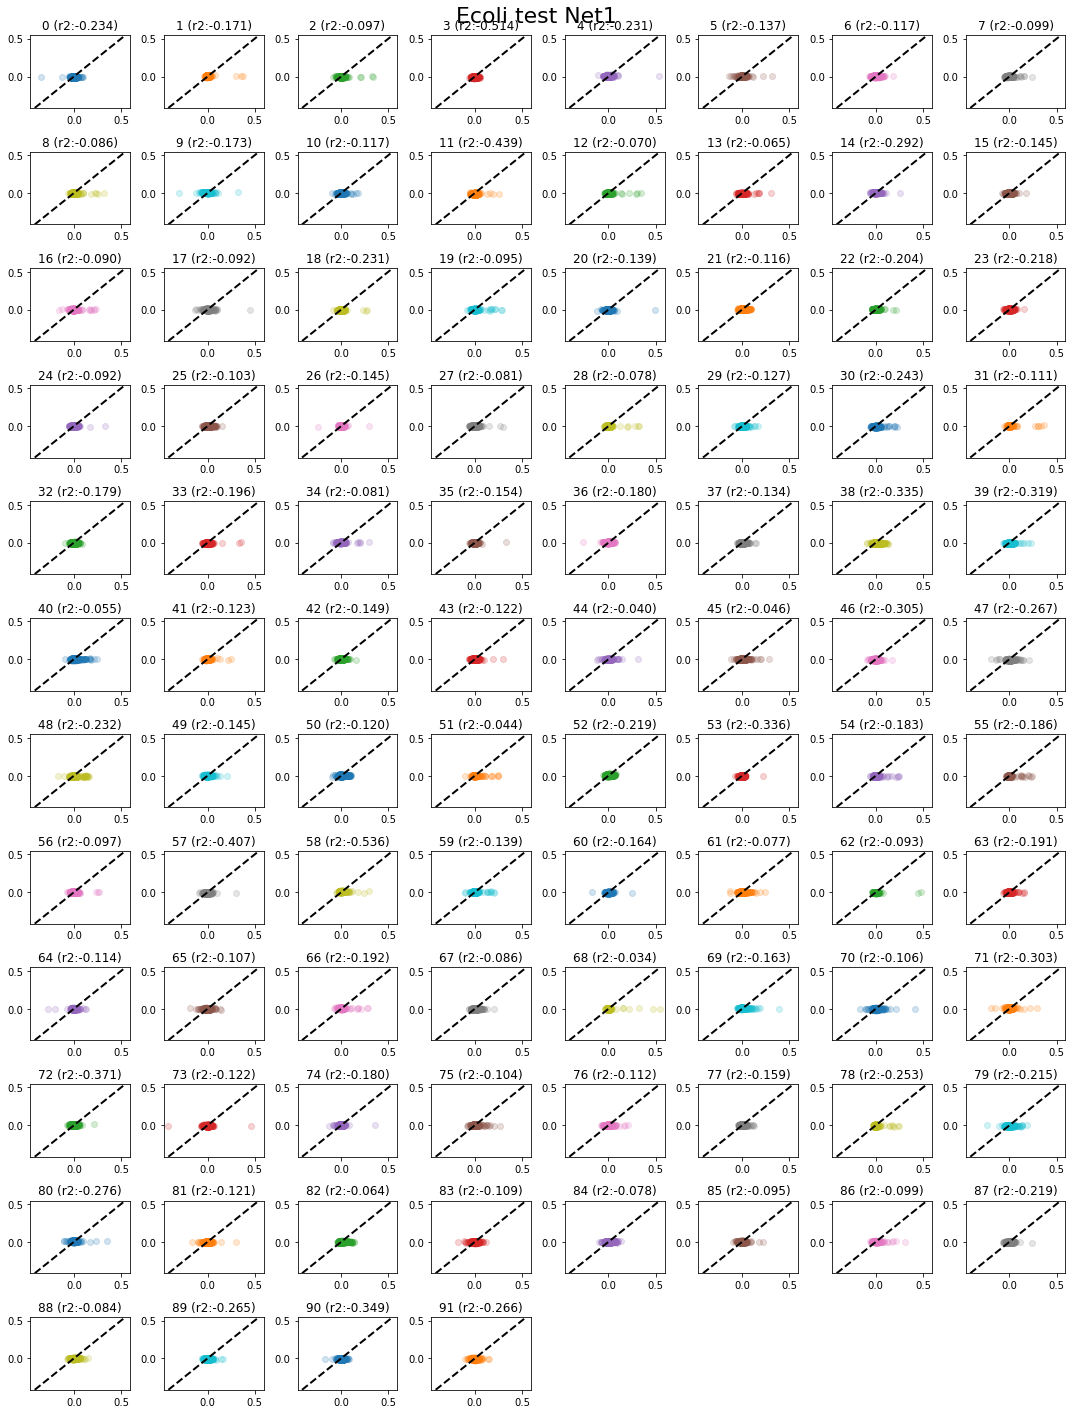

In [43]:
yfull_train_pred = net_regr1.predict(Xfull_train)
    

view_multi_parity("Ecoli test Net1", 
    yfull_train, 
    yfull_train_pred,
    rigid=True)

For all tasks, overfitting to "not in iModulon"
* are any iMods better than others?
* do an initial skorch search to see if any hyperparams stand out?
* then dip back to data aug... cross val
* mbinarized



# Next ideas
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one